# Data Analysis

In [ ]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/ECE183DB_Data/Data1')

FileNotFoundError: ignored

## Pre-reqs

Import the following modules to plot a pretty graph

In [ ]:
#Loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style('whitegrid')
# plt.style.use('fivethirtyeight')
from scipy.optimize import least_squares
from scipy.stats import norm
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


###Planar Trajectory Data 

In [ ]:
colnames = ['time','omega_shoulder','omega_elbow','omega_wrist', 'x','y','phi']

In [ ]:
# INITIAL_OFFSET
x_off = -0.3917
y_off = 0.3784

def unmapX(x_webot):
    x_true = x_webot + x_off
    return x_true

def unmapZ(z_webot):
    z_true = z_webot + y_off
    return z_true

###Importing data

In [ ]:
L = 10
W = 10

In [ ]:
#add correct path and make sure the sorting of data matches with names

# data = pd.read_csv('/content/gdrive/MyDrive/ECE183DB_Data/Data1/move_to_tray_endEffector.csv',delimiter=',', header=None, names=['x','y','phi'])
data = pd.read_csv('/content/gdrive/MyDrive/Education/Electrical Engineering/EE 183DA/Data/move_to_tray_endEffector.csv',delimiter=',', 
                   skiprows=[0],header=None, names=['index','x','y','z'])

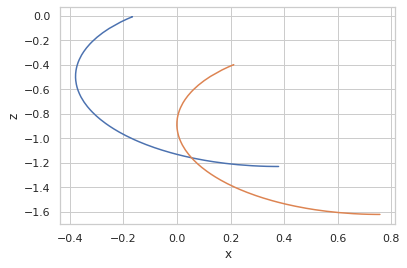

In [ ]:
#Building our x-axis data 0 to length of our data
#time_input = data.values.T[0]  #x-axis for plotting
#omega_shoulder_input = data.values.T[1]
#omega_elbow_input = data.values.T[2]
#omega_wrist_input = data.values.T[3]

#outputs: end effector coordinates 
x_webots = 1*(data.x.values.T)
z_webots = 1*(data.z.values.T)

x_true = unmapX(x_webots)
z_true = unmapZ(z_webots)
#phi_webots = data.values.T[6] 
plt.plot(z_webots,x_webots,label='Webots')
plt.plot(z_true,x_true,label='Actual')
plt.xlabel('x')
plt.ylabel('z')
plt.show()

## Semira's Codes


In [ ]:
import numpy as np
from copy import deepcopy
from functools import reduce
import matplotlib.pyplot as plt

L1_VALUE = 0.3302
L2_VALUE = 0.2794
L3_VALUE = 0.1016
L4_VALUE = 0.2286
theta1_0 =-1.91829
theta2_0 = -1.22836
theta3_0= 1.56573
def Translate(d): 
  #Translate returns translation matrix 
  #returns translation matrix using displacement d 
  T = np.array(((1,0,0,d), (0,1,0,0), (0,0,1,0), (0,0,0,1)))
  return T

def Rotate(theta):
  #  function returns rotation matrix 
  #input angle theta is used to create 3x3 rotation matrix 
  c = np.cos(theta)
  s = np.sin(theta)
  R = np.array(((c,-s,0,0),(s,c,0,0),(0,0,1,0),(0,0,0,1)))
  return R
  



# code for inverse kinematics 
#function returns calculated joint angles in degrees given the end effector coordinates 

def inv_kinematics(x_goal,y_goal,phi_goal):
  l1 = L1_VALUE    #length of the first segment 
  l2 = L2_VALUE    #length of the second segment
  l3 = L3_VALUE     #length of the third segment in inches
  #b = 10    #length of the gripper in inches
  
  l4 = L4_VALUE     
  x1 = x_goal - l4*np.cos(phi_goal)
  y1 = y_goal - l4*np.sin(phi_goal)
  A = -2*l1*x1
  B = -2*l1*y1
  alpha = np.arctan2(B/(np.sqrt(A**2+B**2)), A/(np.sqrt(A**2+B**2)))
  #sign = np.array([1,-1])
  theta1 = alpha + np.arccos(-(x1**2+y1**2+l1**2-l2**2)/(2*l1*np.sqrt(x1**2+y1**2)))
  theta2 = np.arccos((x1**2+y1**2-l1**2-l2**2)/(2*l1*l2)) 
  theta3 = phi_goal-theta1-theta2
  #theta_1 = np.rad2deg(theta1)
  #theta_2 = np.rad2deg(theta2)
  #theta_3 = np.rad2deg(theta3)

  return theta1, theta2, theta3

# Quintic Polynomial 
def quintic_polynomial(theta0,theta_f, t_f, t):
    #constraints: 
    theta_0 = theta0; # initial position is theta0
    dot_theta_0 = 0  #initial velocity is zero 
    dot_theta_f = 0  #final velocity is zero 
    double_dot_theta_0 = 0
    double_dot_theta_f = 0

    #calculated coefficients 
    a0 = theta_0
    a1 = dot_theta_0
    a2 = double_dot_theta_0/2
    a3 = (20*theta_f-20*theta_0 - (8*dot_theta_f + 12*dot_theta_0)*t_f - (3*double_dot_theta_0 - double_dot_theta_f)*t_f**2)/(2*t_f**3)
    a4 = (30*theta_0 - 30*theta_f +(14*dot_theta_f + 16*dot_theta_0)*t_f +(3*double_dot_theta_0 - 2*double_dot_theta_f)*t_f**2)/(2*t_f**4)
    a5 = (12*theta_f-12*theta_0 - (6*dot_theta_f + 6*dot_theta_0)*t_f - (double_dot_theta_0 - double_dot_theta_f)*t_f**2)/(2*t_f**5)

    # angular position at time step t 
    theta_t = a0 + a1*t + a2*t**2 + a3*t**3 + a4*t**4 + a5*t**5 

    # angular velocity at time step t 
    angular_vel = a1 + 2*a2*t + 3*a3*t**2 + 4*a4*t**3 + 5*a5*t**4 

    # angular acceleration at time step t
    angular_acc = 2*a2 + 6*a3*t + 12*a4*t**2 + 20*a5*t**3

    return theta_t,angular_vel,angular_acc



def generateEndCoordinates(theta1_, theta2_, theta3_, time, theta_sampling_rate=0.001):
    '''
    Takes in parameters theta1, theta2, theta3
    and returns waypoints on each of the points
    '''
    INCH_TO_METER = 0.0254
    L1 = L1_VALUE  #length of the first segment 
    L2 = L2_VALUE  #length of the second segment
    L3 = L3_VALUE    #length of the third segment 
    #b = 10*INCH_TO_METER   #length of the gripper
    L4 = L4_VALUE 

    # Initial angles
    theta1_0 =-1.91829
    theta2_0 = -1.22836
    theta3_0= 1.56573
    # INITIAL_OFFSET
    x_off = -0.3917
    y_off = 0.3784

    x = np.array([0., x_off+L1, x_off+L1+L2, x_off+L4+L1+L2]);
    y = np.array([0., y_off+0., y_off+0., y_off+0.]);
    X_arr = list()
    Y_arr = list()
    V_arr = list() #angular velocities for all joints
    A_arr = list() #angular acceleration for all joints
    Angle_arr =list() #angular position of joints
    V1 = list() #angular velocities for joint 1 
    V2 = list() #angular velocities for joint 2
    V3 = list() #angular velocities for joint 3 

    time_arr = np.arange(0,time,0.001)

    theta1 = np.deg2rad(theta1_)
    theta2 = np.deg2rad(theta2_)
    theta3 = np.deg2rad(theta3_)
    #Product of all 3 angles will be a multiple of LCM of 3 angles
    theta = theta1 * theta2 * theta3

    # Accounting for negative values of angles.
    if theta < 0:
        theta = -theta

    # Generate empty lists
    X_arr = list()
    Y_arr = list()
    Phi_arr = list()
    Angle_arr = list()
    Acc_arr = list()
    Vel_arr = list()


    for i in time_arr:

      tt1,ang_vel1,ang_acc1 = quintic_polynomial(theta1_0,theta1,time,i)
      tt2,ang_vel2,ang_acc2 = quintic_polynomial(theta2_0,theta2,time,i)
      tt3,ang_vel3,ang_acc3 = quintic_polynomial(theta3_0,theta3,time,i)
      
      ang_vel = [ang_vel1, ang_vel2, ang_vel3]
      ang_acc = [ang_acc1, ang_acc2, ang_acc3]
      angle_arr = [tt1, tt2, tt3]
      phi = tt1 + tt2 + tt3
        # transformation matrices
        # rotation matrices
      R1 = Rotate(tt1)
      R2 = Rotate(tt2)
      R3 = Rotate(tt3)

        # translation matrices
        # parameters are link lengths
      T2 = Translate(L1)
      T3 = Translate(L2)
      T4 = Translate(L4)

        # finding second point
        # transformation matrix
      a = np.array([[0],[0],[0],[1]])
      Y_iter1 = reduce(np.dot, [R1,T2])

        # Finding new coordinates
      Y1 = np.dot(Y_iter1, a)
      x[1] = Y1[0]
      y[1] = Y1[1]

        # finding third point
        # transformation matrix
      Y_iter2 = reduce(np.dot, [R1,T2,R2,T3])
        # Finding new coordinates
      Y2 = np.dot(Y_iter2, a)
      x[2] = Y2[0]
      y[2] = Y2[1]

        # finding fourth point
        # transformation matrix
      Y_iter3 = reduce(np.dot, [R1,T2,R2,T3,R3,T4])

        # Finding new coordinates
      Y3 = np.dot(Y_iter3, a)
      x[3] = Y3[0]
      y[3] = Y3[1]

      X_arr.append(deepcopy(x))
      Y_arr.append(deepcopy(y))
      Phi_arr.append(phi)
      Angle_arr.append(deepcopy(angle_arr))
      Acc_arr.append(deepcopy(ang_acc))
      Vel_arr.append(deepcopy(ang_vel))

    X_arr_ret = np.array(X_arr)
    Y_arr_ret = np.array(Y_arr)
    Phi_ret = np.array(Phi_arr)
    Angle_ret = np.array(Angle_arr)
    Acc_ret = np.array(Acc_arr)
    Vel_ret = np.array(Vel_arr)
    return X_arr_ret[:,3],Y_arr_ret[:,3],Phi_ret,Angle_ret,Acc_ret,Vel_ret


In [ ]:
theta1,theta2,theta3 = inv_kinematics(1.3223,-0.9618,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in arccos
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in arccos


Text(0.5, 0.98, 'Joint 1 - Quintic Polynomial Trajectory')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


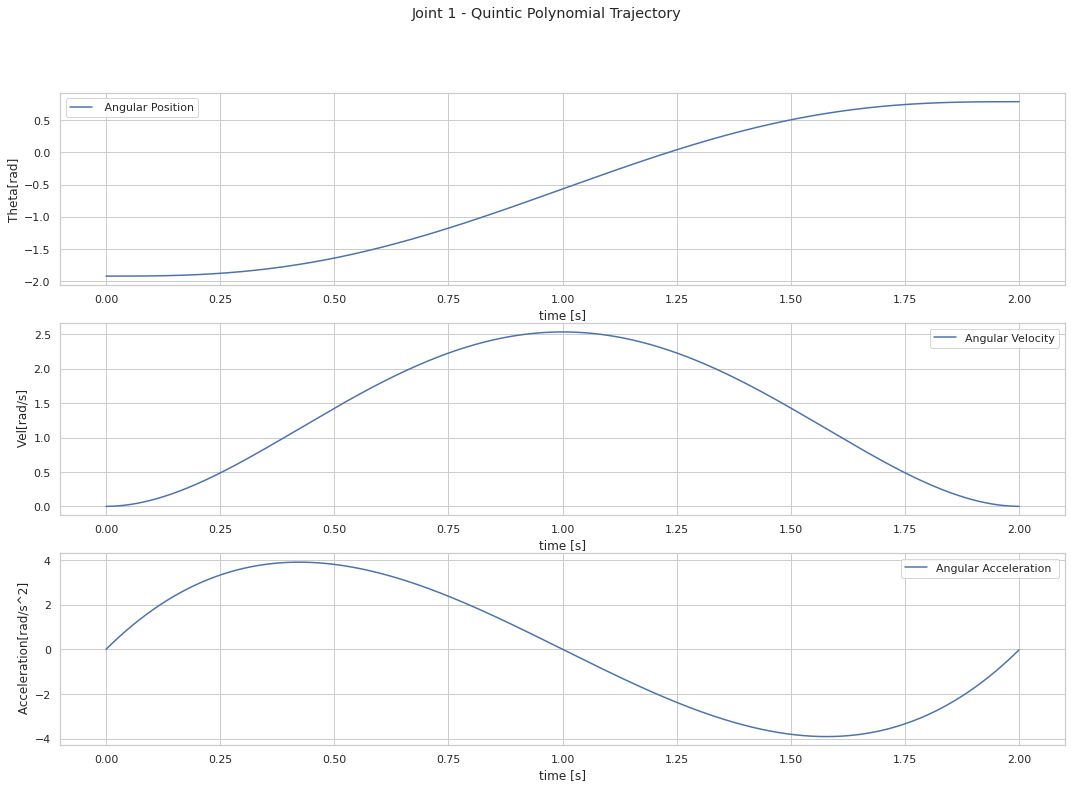

In [ ]:
_,_,_,Angle_ret,_,_ = (generateEndCoordinates(45, 45, 45, 2, theta_sampling_rate=0.001))
theta1_ = (Angle_ret[:,0])
_,_,_,_,Acc,_ = generateEndCoordinates(45, 45, 45, 2, theta_sampling_rate=0.001)
_,_,_,_,_,Vel = generateEndCoordinates(45, 45, 45, 2, theta_sampling_rate=0.001)
acc1 = Acc[:,0]
vel1 = Vel[:,0]
acc2 = Acc[:,1]
vel2 = Vel[:,1]
acc3 = Acc[:,2]
vel3 = Vel[:,2]
t = np.linspace(0,2,acc1.size)

fig, ax = plt.subplots(3,figsize=(18,12))
ax[0].plot(t,theta1_,label =' Angular Position')
ax[1].plot(t,vel1,label='Angular Velocity')
ax[2].plot(t,acc1, label = 'Angular Acceleration ')
ax[0].legend()
ax[1].legend()
ax[2].legend()
#plt.xlabel('time [s]')
ax[0].set(xlabel='time [s]', ylabel='Theta[rad]')
ax[1].set(xlabel='time [s]', ylabel=' Vel[rad/s]')
ax[2].set(xlabel='time [s]', ylabel=' Acceleration[rad/s^2]')

fig.suptitle('Joint 1 - Quintic Polynomial Trajectory')

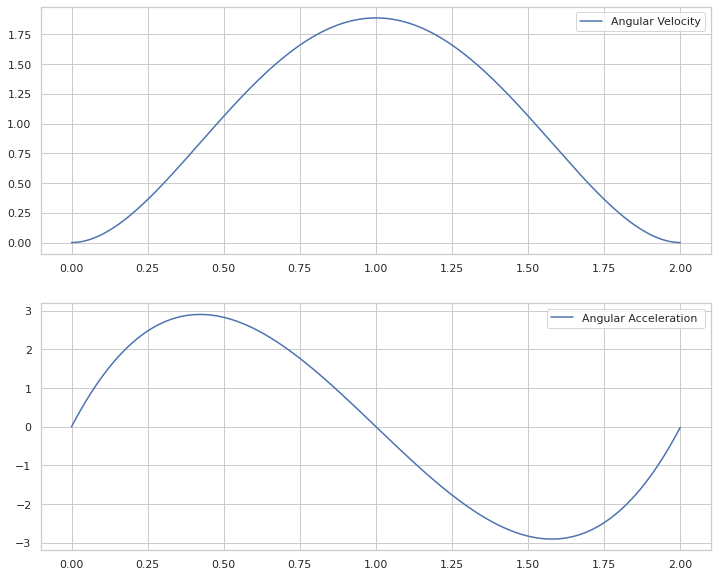

In [ ]:
t2 = np.linspace(0,2,acc2.size)
fig, ax = plt.subplots(2,figsize=(12,10))
ax[0].plot(t2,vel2,label='Angular Velocity')
ax[1].plot(t2,acc2, label = 'Angular Acceleration ')
ax[0].legend()
ax[1].legend()

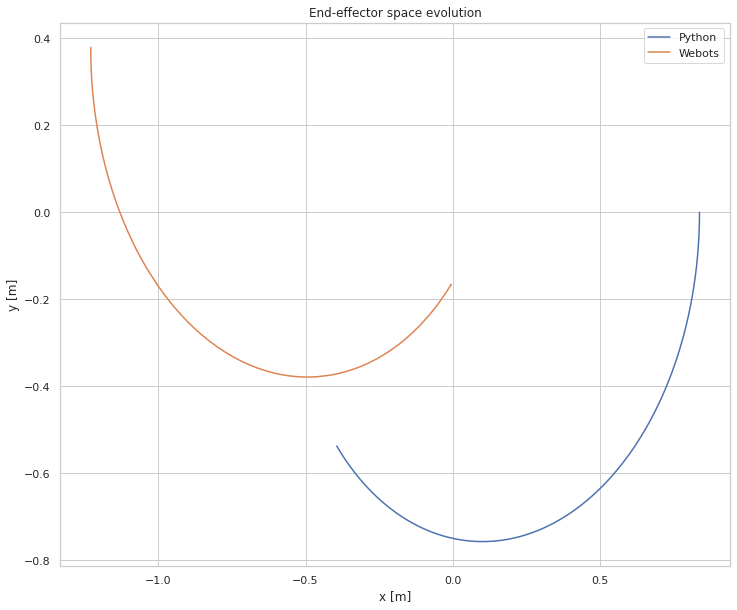

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
X,Y,_,_,_,_ = generateEndCoordinates(0, 0, 0, 6, theta_sampling_rate=0.001)
plt.plot(X,Y,label='Python')
plt.plot(x_webots,z_webots,label='Webots')
# plt.plot(x_true,z_true,label='Webots')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('End-effector space evolution')
plt.show()

## AJ's Code

In [ ]:
import numpy as np
import csv
from copy import deepcopy
from functools import reduce

# Parameter values
L1_VALUE = 0.3302
L2_VALUE = 0.2794
L3_VALUE = 0.1016
L4_VALUE = 0.2286

class wayPoints:
    def __init__(self,filename = None):
        self.waypoints = []
        if filename != None:
            self.readFromFile(filename)
        
    def addWP(self,wp):
        #wp is (j1,j2,jn,t) tuple
        self.waypoints.append(wp)
        
    def readFromFile(self,filename):
        #assuming CSV file
        with open(filename,newline='') as wpFile:
            wpReader = csv.reader(wpFile, delimiter=',', quotechar='|')
            for wp in wpReader:
                newRow = [float(val) for val in wp]
                self.addWP(tuple(newRow))

class trajectoryPlanner:
    def __init__(self, jointNum):
        self.jointNum = jointNum
        self.method = None
        
    def waypointsParse(self,wayP,method):
        #interpret a list of waypoints
        #list of tuples, [(joint1_i,joint2_i,...,t_i)...]
        #interpolate between points with method
        self.method = method
        
        if len(wayP) < 2:
            print("not enough waypoints!")
            return
        
        #check for positive time increments
        tLast = 0
        for waypoint in wayP:
            tDiff = waypoint[-1]-tLast
            tLast = waypoint[-1]
            if tDiff < 0:
                print("not a positive time sequence!")
                return
        
        if len(wayP[0])-1 != self.jointNum:
            print("waypoints/joint mismatch!")
            return
        
        self.joints = []
        for i in range(self.jointNum):
            self.joints.append([])
        
        #split waypoints into individual [(position,time)] per joint
        for waypoint in wayP:
            for i in range(self.jointNum):
                self.joints[i].append([waypoint[i],waypoint[-1]])

        #joints[] is now a list of points,time per joint
        if method == "cubic":
            #cubic interpolation
            self.cubicInterpolate()
        elif method == "quintic":
            #quintic interpolation
            self.quinticInterpolate()
        elif method == "trapVel":
            self.trapVelInterpolate()
        else:
            pass
            
    def trapVelInterpolate(self):
        #interpolate between points with trapezoidal velocity
        #later - respect max velocity and acceleration constraints
        #no blending - stop at waypoints.
        pass
        
            
    def cubicInterpolate(self):
        #for each joint, calculate the coefficients for the cubic
        #interpolating polynomials
        
        #modify joints from [position,time] to [position,velocity,time]
        self.cubicCoeffs = []
        for j in self.joints:
            self.cubicCoeffs.append([])
        
        #null starting and ending velocity
        for j in self.joints:
            for i in range(len(j)):
                j[i].insert(1,0)
            
        #compute intermediate velocities
        #if the last and next velocities are of different sign, make 
        #velocity = 0 at that point.    
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(pos-lastPos)/(tdiffLast)
                velBefore = (j[i][0]-j[i-1][0])/(j[i][-1]-j[i-1][-1])
                #(nextPos-pos)/(tdiffNext)
                velAfter = (j[i+1][0]-j[i][0])/(j[i+1][-1]-j[i][-1])
                if sign(velBefore) == sign(velAfter):
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                else:
                    # intermediateVelocity = 0
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                j[i][1] = intermediateVelocity
        
        #now, do the interpolation
        #treat each points starting time as 0, simpler math
        for num,j in enumerate(self.joints):
            for i in range(len(j)-1):
                #calculate a3...a0 for the cubic polynomial between
                #each pair of points
                
                qi = j[i][0]
                qi_dot = j[i][1]
                qf = j[i+1][0]
                qf_dot = j[i+1][1]
                tf = j[i+1][-1]-j[i][-1]
                
                A = np.array([[1,0,0,0],[0,1,0,0],[1,tf,tf**2,tf**3],[0,1,2*tf,3*tf**2]])
                B = np.array([[qi],[qi_dot],[qf],[qf_dot]])
                coeffs = np.linalg.solve(A,B)
                coeffs = np.append(coeffs,tf)
                self.cubicCoeffs[num].append(coeffs)
                
                
        
    def quinticInterpolate(self):
        #same as cubic but with continuous accelerations
        
        #modify joints from [position,time] to [position,velocity,accel,time]
        self.quinticCoeffs = []
        for j in self.joints:
            self.quinticCoeffs.append([])
        
        #null starting and ending velocity and acceleration
        for j in self.joints:
            for i in range(len(j)):
                j[i].insert(1,0)
                j[i].insert(1,0)
            
        #compute intermediate velocities
        #if the last and next velocities are of different sign, make 
        #velocity = 0 at that point.    
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(pos-lastPos)/(tdiffLast)
                velBefore = (j[i][0]-j[i-1][0])/(j[i][-1]-j[i-1][-1])
                #(nextPos-pos)/(tdiffNext)
                velAfter = (j[i+1][0]-j[i][0])/(j[i+1][-1]-j[i][-1])
                if sign(velBefore) == sign(velAfter):
                    intermediateVelocity = (1/2)*(velBefore+velAfter)
                else:
                    intermediateVelocity = 0
                j[i][1] = intermediateVelocity
                
        #compute intermediate accelerations
        #if the last an next accel are diff sign, make accel = 0
        #at midpoint
        for j in self.joints:
            for i in range(1,len(j)-1):
                #(vel-lastVel)/(tdiffLast)
                accelBefore = (j[i][1]-j[i-1][1])/(j[i][-1]-j[i-1][-1])
                #(nextVel-vel)/(tdiffNext)
                accelAfter = (j[i+1][1]-j[i][1])/(j[i+1][-1]-j[i][-1])
                if sign(accelBefore) == sign(accelAfter):
                    intermediateAccel = (1/2)*(accelBefore+accelAfter)
                else:
                    intermediateAccel = 0
                j[i][2] = intermediateAccel
        
        #now, do the interpolation
        #treat each points starting time as 0, simpler math
        for num,j in enumerate(self.joints):
            for i in range(len(j)-1):
                #calculate a3...a0 for the cubic polynomial between
                #each pair of points
                
                qi = j[i][0]
                qi_dot = j[i][1]
                qi_ddot = j[i][2]
                qf = j[i+1][0]
                qf_dot = j[i+1][1]
                qf_ddot = j[i+1][2]
                tf = j[i+1][-1]-j[i][-1]
                
                A = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,2,0,0,0],[1,tf,tf**2,tf**3,tf**4,tf**5],[0,1,2*tf,3*tf**2,4*tf**3,5*tf**4],[0,0,2,6*tf,12*tf**2,20*tf**3]])
                B = np.array([[qi],[qi_dot],[qi_ddot],[qf],[qf_dot],[qf_ddot]])
                coeffs = np.linalg.solve(A,B)
                coeffs = np.append(coeffs,tf)
                self.quinticCoeffs[num].append(coeffs)
        
    def calcOutputs(self,Ts):
        
        #calculate p,v,a outputs for each joint
        #sample polynomials with time interval Ts
        
        #self.outputs is a list, [[[j1_pi,j1_vi,j1_ai],...]...]
        self.outputs = []
        for j in self.joints:
            self.outputs.append([])
            
        if self.method == None:
            print("Paths have not been interpolated")
            return
        elif self.method == "cubic":
            i = 0
            for joint in self.cubicCoeffs:
                for j, c in enumerate(joint):
                    if j == 0:
                        #create 1st value
                        _t = 0
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2
                        a = 2*c[2] + 6*c[3]*_t
                        self.outputs[i].append([p,v,a])
                        
                    for _t in np.arange(Ts,c[-1]+Ts,Ts):
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2
                        a = 2*c[2] + 6*c[3]*_t
                        self.outputs[i].append([p,v,a])
                        
                i = i + 1
        elif self.method == "quintic":
            i = 0
            for joint in self.quinticCoeffs:
                for j, c in enumerate(joint):
                    if j == 0:
                        #create 1st value
                        _t = 0
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3 + c[4]*_t**4 + c[5]*_t**5
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2 + 4*c[4]*_t**3 + 5*c[5]*_t**4
                        a = 2*c[2] + 6*c[3]*_t + 12*c[4]*_t**2 + 20*c[5]*_t**3
                        self.outputs[i].append([p,v,a])
                        
                    for _t in np.arange(Ts,c[-1]+Ts,Ts):
                        p = c[0] + c[1]*_t + c[2]*_t**2 + c[3]*_t**3 + c[4]*_t**4 + c[5]*_t**5
                        v = c[1] + 2*c[2]*_t + 3*c[3]*_t**2 + 4*c[4]*_t**3 + 5*c[5]*_t**4
                        a = 2*c[2] + 6*c[3]*_t + 12*c[4]*_t**2 + 20*c[5]*_t**3
                        self.outputs[i].append([p,v,a])
                        
                i = i + 1
        elif self.method == "trapVel":
            pass
        else:
            return

###################### Required Functions ######################

       
def sign(num):
    if num > 0:
        return 1
    elif num < 0:
        return -1
    else:
        return 0

def speedChange(waypoints, multiplier):
    newPoints = []
    for i in range(len(waypoints)):
        newPoints.append((waypoints[i][0],waypoints[i][1],waypoints[i][2]*multiplier))
    return newPoints
    
def generateWaypoints(theta1_, theta2_, theta3_, time, theta_sampling_rate=0.003):
    theta1 = np.deg2rad(theta1_)
    theta2 = np.deg2rad(theta2_)
    theta3 = np.deg2rad(theta3_)
    #Product of all 3 angles will be a multiple of LCM of 3 angles
    theta = theta1 * theta2 * theta3

    if theta < 0:
        theta = -theta


    theta_iterator = np.arange(0,theta,theta_sampling_rate)

    waypoints_arr = list()

    time_arr = np.linspace(0, time,theta_iterator.size)
    j = 0
    for i in theta_iterator:
        tt1 = (i* theta1) / theta
        tt2 = (i* theta2) / theta
        tt3 = (i* theta3) / theta
        tuple_saved =  deepcopy( (tt1, tt2, tt3, time_arr[j]) )
        waypoints_arr.append( tuple_saved )
        j +=1
    return waypoints_arr
    
def generateWaypointModified(theta1, theta2, theta3, tf, iteration_steps=0.001):
    '''
    Takes in theta1, theta2, theta3
    returns waypoints

    Input: theta1, theta2, theta3, tf, iteration_steps
    Output: waypoints p1, p2, p3
    '''    
    T = np.arange(0, tf, iteration_steps)
    waypoints_arr = list()

    for i in T:
        pos1,_,_ = cubic_polynomial(np.deg2rad(theta1),tf,i)
        pos2,_,_ = cubic_polynomial(np.deg2rad(theta2),tf,i)
        pos3,_,_ = cubic_polynomial(np.deg2rad(theta3),tf,i)
        waypoints_arr.append((pos1, pos2, pos3, i) )

    return waypoints_arr       
    
###################### Kinematic Modelling Functions ######################

def forward_kinematics(theta1,theta2,theta3) -> np.array:
    '''
    Takes in angle theta1, theta2, theta3
    and returns the coordinates x,y, and phi

    Input: theta1, theta2, theta2
    Output: np.array of outputs [x,y,phi]
    '''
    # Link Parameters
    L1 = L1_VALUE  #length of the first segment 
    L2 = L2_VALUE  #length of the second segment
    L4 = L4_VALUE

    x = np.array([0, L1, L1+L2, L4+L1+L2]);
    y = np.array([0., 0., 0., 0.]);

    # Convert to radians
    tt1 = np.deg2rad(theta1)
    tt2 = np.deg2rad(theta2)
    tt3 = np.deg2rad(theta3)

    # Rotation Matrices
    R1 = Rotate(tt1)
    R2 = Rotate(tt2)
    R3 = Rotate(tt3)

    # Translation Matrices
    # Parameters are link lengths
    T2 = Translate(L1)
    T3 = Translate(L2)
    T4 = Translate(L4)

    # First joint position
    # Transformation matrix

    a = np.array([[0],[0],[0],[1]])
    Y_iter1 = reduce(np.dot, [R1,T2])
    # Finding new coordinates
    Y1 = np.dot(Y_iter1, a)

    x[1] = Y1[0]
    y[1] = Y1[1]

    # Finding third point
    # transformation matrix
    Y_iter2 = reduce(np.dot, [R1,T2,R2,T3])
    # Finding new coordinates
    Y2 = np.dot(Y_iter2, a)
    x[2] = Y2[0]
    y[2] = Y2[1]

    # finding fourth point

    # transformation matrix
    Y_iter3 = reduce(np.dot, [R1,T2,R2,T3,R3,T4])

    # Finding new coordinates
    Y3 = np.dot(Y_iter3, a)

    x[3] = Y3[0]
    y[3] = Y3[1]

    phi = np.rad2deg(tt1+tt2+tt3)
    return x,y,phi

    
def inv_kinematics(x_goal,y_goal,phi_goal_) -> [np.float64, np.float64, np.float64]:
    '''
    Function to derive angles theta1, theta2, theta3
    based on target locations x_goal,y_goal, phi_goal

    Input: x_goal,y_goal,phi_goal
    Output: theta1, theta2, theta3 in degrees
    '''
    phi_goal = np.deg2rad(phi_goal_)
    l1 = L1_VALUE   #length of the first segment 
    l2 = L2_VALUE   #length of the second segment
    l4 = L4_VALUE   
     
    x1 = x_goal - l4*np.cos(phi_goal)
    y1 = y_goal - l4*np.sin(phi_goal)
    A = -2*l1*x1
    B = -2*l1*y1
    alpha = np.arctan2(B/(np.sqrt(A**2+B**2)), A/(np.sqrt(A**2+B**2)))
    #sign = np.array([1,-1])
    theta1 = alpha + np.arccos(-(x1**2+y1**2+l1**2-l2**2)/(2*l1*np.sqrt(x1**2+y1**2)))
    theta2 = np.arccos((x1**2+y1**2-l1**2-l2**2)/(2*l1*l2))
    theta3 = phi_goal-theta1-theta2

    return [np.rad2deg(theta1), np.rad2deg(theta2), np.rad2deg(theta3)]
    
def cubic_polynomial(theta_f, t_f, t):
    #constraints: 
    theta_0 = 0; # initial position is 0
    #dot_theta_0 = 0; %initial velocity is zero 
    #dot_theta_f = 0 %final velocity is zero 

    #calculated coefficients 
    a0 = theta_0
    a1 = 0
    a2 = (3/t_f**2)*(theta_f - theta_0)
    a3 = (-2/t_f**3)*(theta_f - theta_0)

    # angular position at time step t 
    theta_t = a0 + a1*t + a2*t**2 + a3*t**3

    # angular velocity at time step t 
    angular_vel = a1 + 2*a2*t + 3*a3*t**2

    # angular acceleration at time step t
    angular_acc = 2*a2 + 6*a3*t

    return theta_t,angular_vel,angular_acc

###################### Auxiliary Functions ######################


def Translate(d) -> np.array: 
    '''
    Translate returns translation matrix 
    Returns translation matrix using displacement d 

    Input: Distance d from current point
    Output: Array T
    '''
    # T = np.array([[1,0,0,d], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
    T = np.eye(4) + [[0,0,0,d],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
    return T

def Rotate(theta) -> np.array:
    '''
    Function returns rotation matrix 
    Input angle theta is used to create 3x3 rotation matrix 
    '''
    c = np.cos(theta)
    s = np.sin(theta)
    R = np.array([[c,-s,0,0],[s,c,0,0],[0,0,1,0],[0,0,0,1]])
    return R

In [ ]:
theta1_0 =-1.91829
theta2_0 = -1.22836
theta3_0= 1.56573

waypoints = [(theta1_0,theta2_0, theta3_0,0),(0,0,0,6)]
joint = trajectoryPlanner(3)
joint.waypointsParse(waypoints, 'quintic')
Ts = 0.001
joint.calcOutputs(Ts) 
jointOutputs = np.array([joint.outputs[0], joint.outputs[1], joint.outputs[2]])

theta_1_x = np.array(jointOutputs[0][:,0])
theta_2_x = np.array(jointOutputs[1][:,0])
theta_3_x = np.array(jointOutputs[2][:,0])

vel_1_x = np.array(jointOutputs[0][:,1])
vel_2_x = np.array(jointOutputs[1][:,1])
vel_3_x = np.array(jointOutputs[2][:,1])

acc_1_x = np.array(jointOutputs[0][:,2])
acc_2_x = np.array(jointOutputs[1][:,2])
acc_3_x = np.array(jointOutputs[2][:,2])

len_new_data = theta_1_x.size

In [ ]:
x_list = list()
y_list = list()
for i in range(len_new_data):
    x,y,_ = forward_kinematics(np.rad2deg(theta_1_x[i])
    , np.rad2deg(theta_2_x[i])
    , np.rad2deg(theta_3_x[i]))
    x_list.append(x[3])
    y_list.append(y[3])
x_list_np = np.array(x_list)
y_list_np = np.array(y_list)

In [ ]:
x_list_np

array([-0.39415775, -0.39415775, -0.39415775, ...,  0.8382    ,
        0.8382    ,  0.8382    ])

In [ ]:
y_list_np

array([-5.37638943e-01, -5.37638943e-01, -5.37638943e-01, ...,
       -6.93718117e-10, -8.67390106e-11,  2.34621211e-15])

In [ ]:
y_webots

array([ 0.6148,  0.6148,  0.6148, ..., -0.0372, -0.0372, -0.0372])

In [ ]:
x_webots[0] + x_list_np[0]

-0.4004577456888818

In [ ]:
x_webots[0]

-0.0063

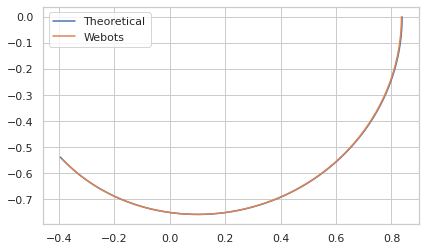

In [ ]:
plt.plot(x_list_np,y_list_np, label='Theoretical')
plt.plot(-x_webots+-0.39415775,z_webots-0.37837835616639887,label='Webots')
plt.legend()

In [ ]:
import random
random.uniform(1.5, 1.9)

1.6325759583322006

## Debugging total length

In [ ]:
np.abs(-1.3417018351452616 + 0.3917375271505858)

0.9499643079946758

In [ ]:
L1_VALUE+ L2_VALUE+ L4_VALUE

0.8382

In [ ]:
print(L1_VALUE,
      L2_VALUE,
      L3_VALUE,
      L4_VALUE)

0.3302 0.2794 0.1016 0.2286


In [ ]:
ORIGIN_WEBOTS = -0.3917375271505858
L1_WEBOTS = -0.7219375259223102 - ORIGIN_WEBOTS
L2_WEBOTS = -1.0013375248786072 + 0.7219375259223102
L4_WEBOTS = -1.3417018351452616 + 1.0013375248786072

### Old Values Before Change

In [ ]:
print(L1_WEBOTS,
      L2_WEBOTS,
      L4_WEBOTS)

-0.3301999987717244 -0.27939999895629697 -0.3403643102666545


# 4.1 Joint Space Analysis

NameError: ignored

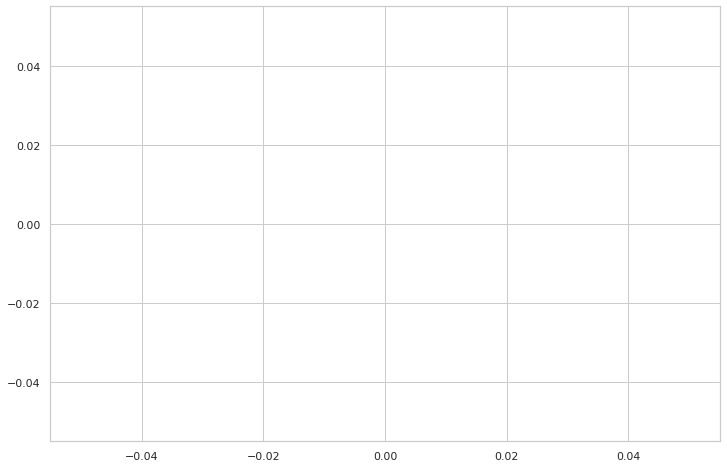

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
# Plot Webots
plt.plot()
# Plot Theoretical
time_arr_theoretical = np.linspace(0,6, theta_2_x.size)
time_arr_webots = np.linspace(0,6,theta1_webots.size)
plt.plot(time_arr_theoretical,theta_1_x, label='Theoretical')
plt.plot(time_arr_webots, np.deg2rad(theta1_webots), label='Webots')
plt.legend()

# Continued Analysis

In [ ]:
# PLot joint angular positions
data_joint = pd.read_csv('/content/gdrive/MyDrive/Education/Electrical Engineering/EE 183DA/Data/move_to_tray_jointPosition.csv',delimiter=',', header=None, names=['index','theta1','theta2','theta3'])

# data_joint = pd.read_csv('/content/gdrive/MyDrive/ECE183DB_Data/Data1/move_to_tray_jointPosition.csv',delimiter=',', header=None, names=['theta1','theta2','theta3'])

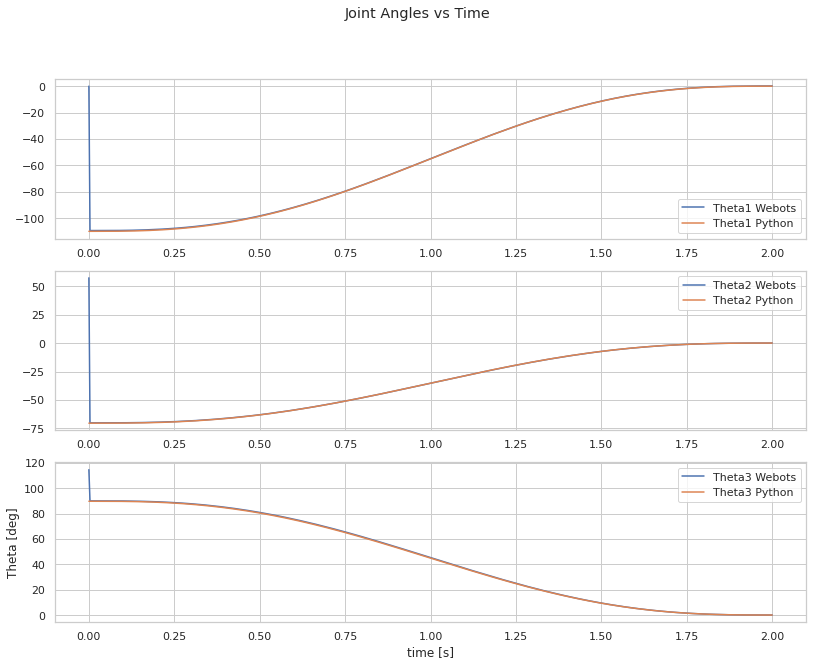

In [ ]:

theta1_webots =np.rad2deg(data_joint.theta1.values.T)
theta2_webots =np.rad2deg(data_joint.theta2.values.T)
theta3_webots =np.rad2deg(data_joint.theta3.values.T)
_,_,_,Angle_ret,_,_ = (generateEndCoordinates(0, 0, 0, 2, theta_sampling_rate=0.001))
theta1_python = np.rad2deg(Angle_ret[:,0])
theta2_python = np.rad2deg(Angle_ret[:,1])
theta3_python = np.rad2deg(Angle_ret[:,2])
time_1 = np.linspace(0,2,theta1_python.size)
time_ = np.linspace(0,2,theta1_webots.size)
fig, ax = plt.subplots(3,figsize=(12,10))
ax[0].plot(time_,theta1_webots,label='Theta1 Webots')
ax[1].plot(time_,theta2_webots,label='Theta2 Webots')
ax[2].plot(time_,theta3_webots,label='Theta3 Webots')
ax[0].plot(time_1,theta1_python,label='Theta1 Python')
ax[1].plot(time_1,theta2_python,label='Theta2 Python')
ax[2].plot(time_1,theta3_python,label='Theta3 Python')
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.xlabel('time [s]')
plt.ylabel('Theta [deg]')
fig.suptitle('Joint Angles vs Time')
plt.show()

### Theta 1

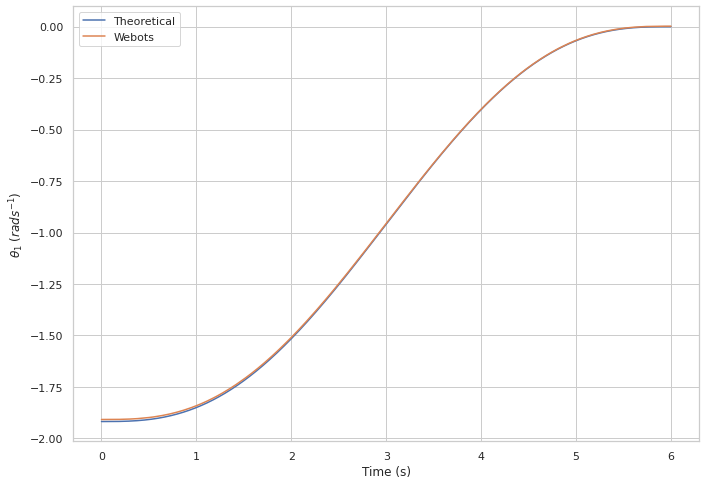

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

theta1_data = data_joint.theta1[1:]
time_arr = np.linspace(0,6, data_joint.theta1.size-1)
time_arr_theoretical = np.linspace(0,6, theta_1_x.size)

plt.plot(time_arr_theoretical, theta_1_x, label='Theoretical')
plt.plot(time_arr, theta1_data, label='Webots')

plt.xlabel('Time (s)')
plt.ylabel(r'$\theta_1$ ($rad s^{-1}$)')
plt.legend()

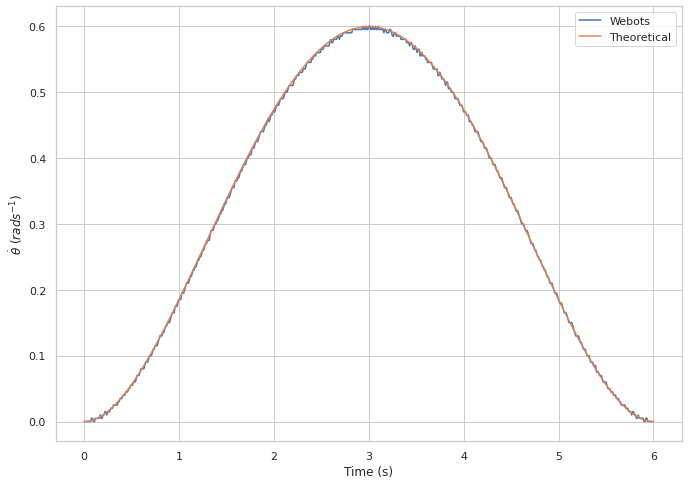

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

w_theta_1 = np.gradient(theta1_data ,time_arr)
w_dot_theta_1 = np.gradient(w_theta_1 ,time_arr)
plt.plot(time_arr,w_theta_1,label='Webots')
plt.plot(time_arr_theoretical, vel_1_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\dot{\theta}$ ($rad s^{-1}$)')
plt.legend()

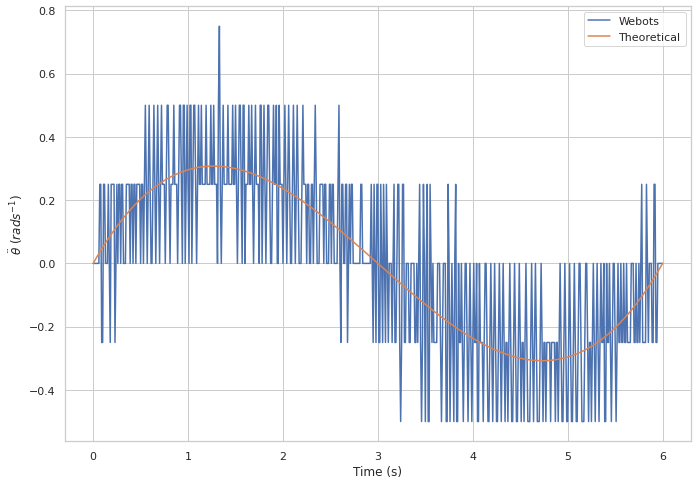

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

plt.plot(time_arr,w_dot_theta_1,label='Webots')
plt.plot(time_arr_theoretical, acc_1_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\ddot{\theta}$ ($rad s^{-1}$)')
plt.legend()

### Theta 2

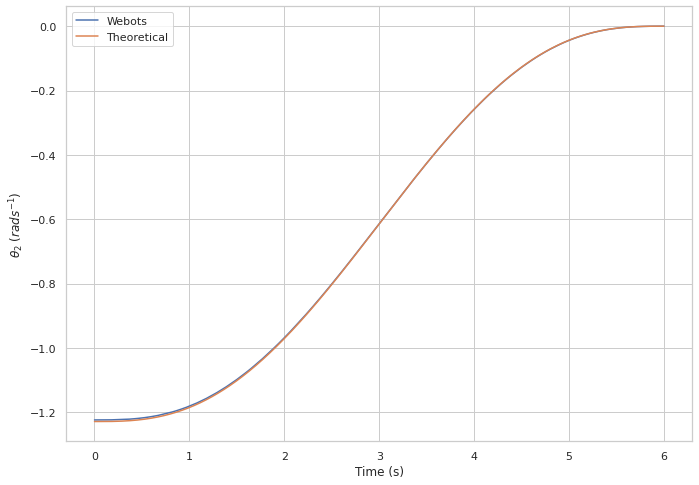

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

theta2_data = data_joint.theta2[1:]
time_arr = np.linspace(0,6, data_joint.theta2.size-1)
plt.plot(time_arr, theta2_data, label='Webots')
plt.plot(time_arr_theoretical, theta_2_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\theta_2$ ($rad s^{-1}$)')
plt.legend()

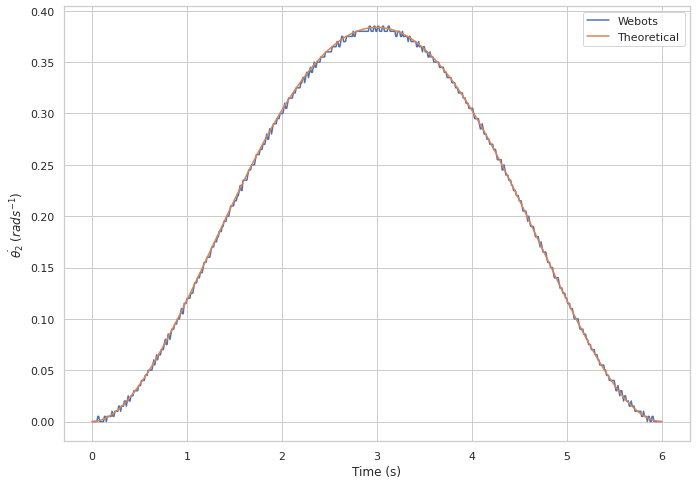

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

w_theta_2 = np.gradient(theta2_data ,time_arr)
w_dot_theta_2 = np.gradient(w_theta_2 ,time_arr)
plt.plot(time_arr,w_theta_2,label='Webots')
plt.plot(time_arr_theoretical, vel_2_x, label='Theoretical')


plt.xlabel('Time (s)')
plt.ylabel(r'$\dot{\theta_2}$ ($rad s^{-1}$)')
plt.legend()

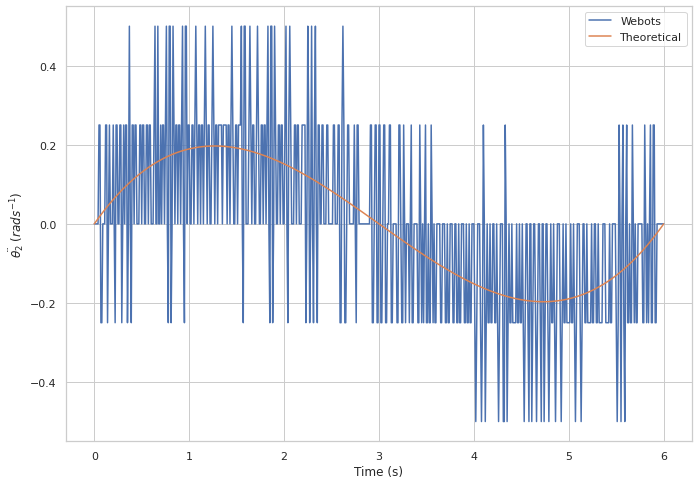

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

plt.plot(time_arr,w_dot_theta_2,label='Webots')
plt.plot(time_arr_theoretical, acc_2_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\ddot{\theta_2}$ ($rad s^{-1}$)')
plt.legend()

### Theta 3

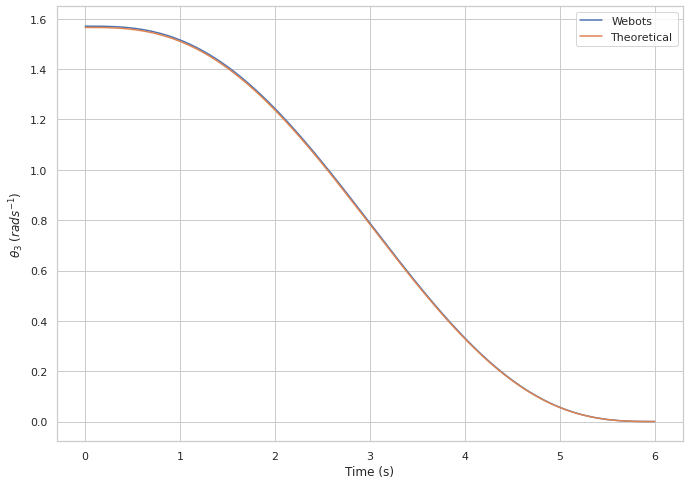

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

theta3_data = data_joint.theta3[1:]
time_arr = np.linspace(0,6, data_joint.theta3.size-1)
plt.plot(time_arr, theta3_data, label='Webots')
plt.plot(time_arr_theoretical, theta_3_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\theta_3$ ($rad s^{-1}$)')
plt.legend()

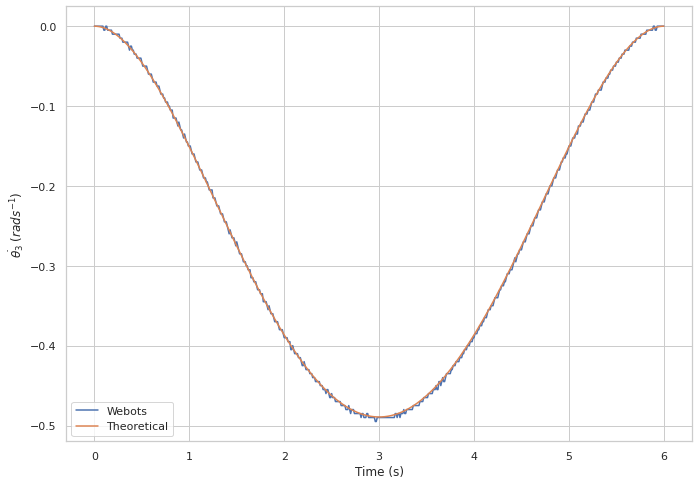

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

w_theta_3 = np.gradient(theta3_data ,time_arr)
w_dot_theta_3 = np.gradient(w_theta_3 ,time_arr)
plt.plot(time_arr,w_theta_3,label='Webots')
plt.plot(time_arr_theoretical, vel_3_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\dot{\theta_3}$ ($rad s^{-1}$)')
plt.legend()

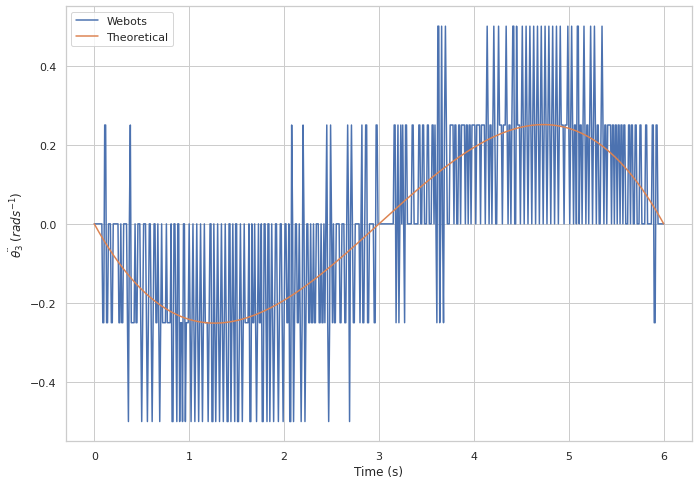

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

plt.plot(time_arr,w_dot_theta_3,label='Webots')
plt.plot(time_arr_theoretical, acc_3_x, label='Theoretical')

plt.xlabel('Time (s)')
plt.ylabel(r'$\ddot{\theta_3}$ ($rad s^{-1}$)')
plt.legend()

Trajectory Test 

In [ ]:
#plot end effector phi angle over time 
_,_,phi,_,_,_ = (generateEndCoordinates(0, 0, 0, 6, theta_sampling_rate=0.001))
time = np.linspace(0,6,phi.size)
phi_webots = np.rad2deg(data.phi.values.T)
phi_deg = np.rad2deg(phi)
plt.plot(time,phi_deg,label='Python')
time_webots = np.linspace(0,6,phi_webots.size)
plt.plot(time_webots,phi_webots,label='Webots')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Phi [deg]')
plt.title('End-effector angle vs time')
plt.show()

AttributeError: ignored

In [ ]:
#plot end effector space evolution over time 
fig, ax = plt.subplots(figsize=(12,10))
X,Y,_,_,_,_ = generateEndCoordinates(0, 0, 0, 6, theta_sampling_rate=0.001)
plt.plot(X,Y,label='Python')
plt.plot(y_webots,x_webots,label='Webots')
plt.legend()
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('End-effector space evolution')
plt.show()

4.2.2 Error in Trajectory of the End Effector